<a href="https://www.kaggle.com/code/rtenorioramirez/proyecto-clasificacion?scriptVersionId=258969637" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Proyecto_Clasificación

## Obtén tu API de Kaggle:
- yo uso mi json de kaggle para esto, más facil y practico

## Configura el Directorio de Kaggle y Descarga el Dataset:
- ENl data set es del concurso de kaggle rsna del 2023 , las imagenes de radiografia y lo que es MRI se encuentra en un propio formato DOCM o algo asi, sin embargo para este concurso las almas caritativas de Keras dieron el codigo para pasarlo a png y además tambien otorgaron el dataset ya pasado a png, ese es el dataset que estamos llamando y usando.

In [2]:
import kagglehub
import os

# Descarga la última versión y guarda la ruta
dataset_path = kagglehub.dataset_download("awsaf49/rsna-atd-512x512-png-v2-dataset")

print(f"Dataset descargado y descomprimido en: {dataset_path}")
# Verás que los archivos están listos para ser usados
print("Contenido del directorio:", os.listdir(dataset_path))

Dataset descargado y descomprimido en: /kaggle/input/rsna-atd-512x512-png-v2-dataset
Contenido del directorio: ['sample_submission.csv', 'train_series_meta.csv', 'train_images', 'train.csv', 'test.csv', 'test_series_meta.csv', 'test_images']


## Kaggle datase
-Ruta para cuando se entrena en kaggle

In [3]:
dataset_path = "/kaggle/input/rsna-atd-512x512-png-v2-dataset"

## Entorno de Trabajo, Carga de Metadatos y División de Datos
- Es una verdadera tragedia ir buscando que metada datos se encuentra en que modelo, no se si es buena practicas pero suele ponerlo arriba de todo y de ahi modificar si es necesario algo.

In [4]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Tu clase de configuración es perfecta
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256] # Reducimos a 256 para entrenar más rápido
    BATCH_SIZE = 32 # Reducimos un poco por si la GPU de Colab tiene memoria limitada
    EPOCHS = 5
    # Las columnas objetivo que definiste son correctas
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

2025-08-29 23:10:04.681247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756509004.881474      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756509004.945337      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Preparar el DataFrame:

In [5]:
BASE_PATH = f"{dataset_path}/train_images"
CSV_PATH = f"{dataset_path}/train.csv"

# Cargar el dataframe
dataframe = pd.read_csv(CSV_PATH)


def create_image_path(row):
    # La ruta base 
    return f"{BASE_PATH}/{row.patient_id}/{row.series_id}/{row.instance_number}.png"

dataframe["image_path"] = dataframe.apply(create_image_path, axis=1)

# Convertir las columnas objetivo a un formato numérico adecuado
for col in config.TARGET_COLS:
    dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')

# Eliminar filas con valores NaN en las columnas objetivo si las hubiera
dataframe.dropna(subset=config.TARGET_COLS, inplace=True)

print(f"DataFrame cargado con {dataframe.shape[0]} imágenes.")


DataFrame cargado con 13015 imágenes.


## División Estratificada de Datos:
- Si el paciente esta en ambos train y validation seria cross-contamination y perjudicaria al modelo.
- Existe validation test set en este dataset y sin embargo estoy dividiendo el train y usar una porción para lo que es validation ( al final no use test)

In [6]:
# Tu función para dividir
#def split_group(group, test_size=0.2):
 #   if len(group) <= 1: # Si el grupo es muy pequeño, no se puede dividir
 #       return group, pd.DataFrame()
 #   return train_test_split(group, test_size=test_size, random_state=config.SEED)
 # Funcion de arriba para dividir pero ya esta dividido el data en train y validation pero no la vamos usar

# Agrupamos por paciente para que las imágenes del mismo paciente no estén en train y val a la vez
grouped = dataframe.groupby('patient_id')
train_pids, val_pids = train_test_split(list(grouped.groups.keys()), test_size=0.2, random_state=config.SEED)

train_data = dataframe[dataframe['patient_id'].isin(train_pids)].reset_index(drop=True)
val_data = dataframe[dataframe['patient_id'].isin(val_pids)].reset_index(drop=True)

print(f"Datos de entrenamiento: {train_data.shape}")
print(f"Datos de validación: {val_data.shape}")

Datos de entrenamiento: (10675, 21)
Datos de validación: (2340, 21)


## Creación del Pipeline de Datos con tf.data
- Se procesa los datos batches, float 32, prefectch y shuffle y un pequeño augmenter, pero queda la duda ¿seria bueno augmenter cuando las radiografias no suelen cambiar de posición y son muy parecidas y fijas entre si? investigar en foros de kaggle para la proxima

In [9]:

augmenter = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

# Decoder
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    labels = (
        tf.cast(label[0:1], tf.float32),
        tf.cast(label[1:2], tf.float32),
        tf.cast(label[2:5], tf.float32),
        tf.cast(label[5:8], tf.float32),
        tf.cast(label[8:11], tf.float32)
    )
    return (image, labels)

# Augmentation
def apply_augmentation(images, labels):
    # Simplemente llama al objeto 'augmenter' que creamos antes.
    return (augmenter(images, training=True), labels)


# Añadimos el parámetro 'shuffle_data' que por defecto es True
def build_dataset(image_paths, labels, shuffle_data=True):
    
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
    )


    # Solo barajamos y aplicamos aumentos si estamos construyendo el dataset de entrenamiento
    if shuffle_data:
        ds = ds.shuffle(config.BATCH_SIZE * 10)
        ds = ds.map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)

    # El final es igual para ambos (batch y prefetch)
    ds = ds.batch(config.BATCH_SIZE).prefetch(config.AUTOTUNE)

    return ds


# 1. Crear el dataset de ENTRENAMIENTO
#    Aquí SÍ se baraja, porque 'shuffle_data' es True por defecto.
train_paths = train_data.image_path.tolist()
train_labels = train_data[config.TARGET_COLS].values
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)

# 2. Crear el dataset de VALIDACIÓN
#    Aquí NO se baraja, porque explícitamente ponemos 'shuffle_data=False'.
val_paths = val_data.image_path.tolist()
val_labels = val_data[config.TARGET_COLS].values
val_ds = build_dataset(image_paths=val_paths, labels=val_labels, shuffle_data=False)

## Construcción del Modelo
- Se una funcion que podra adaptarse y recibir los modelos, de esta forma solo llamaremos a los modelos y estos se adaptaran a lo que deben clasificar

In [10]:
def get_model(base_model_fn):
    # 1. Capa de entrada
    inputs = keras.Input(shape=(*config.IMAGE_SIZE, 3), name="image_input")

    # 2. Modelo base (pre-entrenado y congelado)
    base_model = base_model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    # 3. Capas personalizadas
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.3)(x)

    # 4. Las "Cabezas" de Salida (una por cada tarea)
    # Tareas binarias (lesión sí/no)
    bowel_output = keras.layers.Dense(1, activation='sigmoid', name='bowel')(x)
    extravasation_output = keras.layers.Dense(1, activation='sigmoid', name='extravasation')(x)

    # Tareas categóricas (sano, bajo, alto)
    kidney_output = keras.layers.Dense(3, activation='softmax', name='kidney')(x)
    liver_output = keras.layers.Dense(3, activation='softmax', name='liver')(x)
    spleen_output = keras.layers.Dense(3, activation='softmax', name='spleen')(x)

    # 5. Construir el modelo final
    model = keras.Model(
        inputs=inputs,
        outputs=[bowel_output, extravasation_output, kidney_output, liver_output, spleen_output]
    )
    return model



##model.summary() observacion de todas las capas del modelo
## no se como hacer model.summary sin que salga todo el modelo completo y al ser modelos robustos se llena completamente la pantalla

## Historial de entrenamiento

In [11]:
# Diccionario para guardar los historiales de entrenamiento de cada modelo
histories = {}

Compilación y Entrenamiento

## Metricas
- En teoria no deberia ser necesario que esten presentes en el training hasta donde recordaba pero no encuentro como llamar las metricas sin que estas se presente en training y sin muchos errores, buscar documentación tensorflow.

In [12]:
import tensorflow as tf
from tensorflow import keras

# 1. Define la lista completa de métricas
METRICS_BINARY = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_CATEGORICAL = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# 2. Asigna la lista completa a cada salida del modelo
losses = {
    "bowel": tf.keras.losses.BinaryCrossentropy(),
    "extravasation": tf.keras.losses.BinaryCrossentropy(),
    "kidney": tf.keras.losses.CategoricalCrossentropy(),
    "liver": tf.keras.losses.CategoricalCrossentropy(),
    "spleen": tf.keras.losses.CategoricalCrossentropy(),
}

metrics = {
    "bowel": METRICS_BINARY,
    "extravasation": METRICS_BINARY,
    "kidney": METRICS_CATEGORICAL,
    "liver": METRICS_CATEGORICAL,
    "spleen": METRICS_CATEGORICAL,
}

## Modelos
- Entrenaremos cada modelo y rogar que no demore mucho, si ya no te permiten la gpu entrenar con las de kaggle y despues importar a colab para subir a github ( ver la manera de subir a github desde colab)
- Hay una variable que se puede poner en el .fit para que no se imprima tantas variables y quede más limpio el codigo pero lo dejaremnos asi por ahora arreglar en siguiente versión

In [13]:


# 1. Construir el modelo A
model_efficientnet = get_model(tf.keras.applications.EfficientNetB0)

# 2. Compilar el modelo
model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                           loss=losses,
                           metrics=metrics)

# 3. Entrenar y guardar el historial
print("--- Entrenando Modelo A: EfficientNetB0 ---")
history_efficientnet = model_efficientnet.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds
)
histories['EfficientNetB0'] = history_efficientnet

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Entrenando Modelo A: EfficientNetB0 ---
Epoch 1/5


I0000 00:00:1756509078.066128      98 service.cc:148] XLA service 0x7cb038003670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756509078.066908      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756509080.576510      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/334 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - bowel_accuracy: 0.4010 - bowel_loss: 0.7229 - bowel_precision: 0.5267 - bowel_recall: 0.1389 - extravasation_accuracy: 0.6181 - extravasation_loss: 0.6776 - extravasation_precision: 0.5267 - extravasation_recall: 0.1389 - kidney_accuracy: 0.8663 - kidney_loss: 0.7815 - kidney_precision: 0.8120 - kidney_recall: 0.1528 - liver_accuracy: 0.5069 - liver_loss: 0.9849 - liver_precision: 0.8120 - liver_recall: 0.1528 - loss: 4.2637 - spleen_accuracy: 0.3715 - spleen_loss: 1.0969 - spleen_precision: 0.8120 - spleen_recall: 0.1528 

I0000 00:00:1756509090.565644      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


334/334 ━━━━━━━━━━━━━━━━━━━━ 139s 313ms/step - bowel_accuracy: 0.6439 - bowel_loss: 0.6793 - bowel_precision: 0.7007 - bowel_recall: 0.7684 - extravasation_accuracy: 0.6679 - extravasation_loss: 0.6612 - extravasation_precision: 0.7007 - extravasation_recall: 0.7684 - kidney_accuracy: 0.9108 - kidney_loss: 0.3830 - kidney_precision: 0.7888 - kidney_recall: 0.7220 - liver_accuracy: 0.7778 - liver_loss: 0.6059 - liver_precision: 0.7888 - liver_recall: 0.7220 - loss: 3.2209 - spleen_accuracy: 0.5997 - spleen_loss: 0.8915 - spleen_precision: 0.7888 - spleen_recall: 0.7220 - val_bowel_accuracy: 0.4312 - val_bowel_loss: 0.9279 - val_bowel_precision: 0.6308 - val_bowel_recall: 1.0000 - val_extravasation_accuracy: 0.8303 - val_extravasation_loss: 0.5312 - val_extravasation_precision: 0.6308 - val_extravasation_recall: 1.0000 - val_kidney_accuracy: 0.8423 - val_kidney_loss: 0.9234 - val_kidney_precision: 0.7001 - val_kidney_recall: 0.7001 - val_liver_accuracy: 0.6444 - val_liver_loss: 1.7885 - 

In [15]:
# 1. Construir el modelo B
model_resnet = get_model(tf.keras.applications.ResNet50V2)

# 2. Compilar el modelo
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                     loss=losses,
                     metrics=metrics)

# 3. Entrenar y guardar el historial
print("\n--- Entrenando Modelo B: ResNet50V2 ---")
history_resnet = model_resnet.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds
)
histories['ResNet50V2'] = history_resnet


--- Entrenando Modelo B: ResNet50V2 ---
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 112s 279ms/step - bowel_accuracy: 0.7417 - bowel_loss: 0.5718 - bowel_precision: 0.7272 - bowel_recall: 0.8565 - extravasation_accuracy: 0.7337 - extravasation_loss: 0.5635 - extravasation_precision: 0.7272 - extravasation_recall: 0.8565 - kidney_accuracy: 0.9070 - kidney_loss: 0.3958 - kidney_precision: 0.7846 - kidney_recall: 0.7723 - liver_accuracy: 0.7953 - liver_loss: 0.5799 - liver_precision: 0.7846 - liver_recall: 0.7723 - loss: 2.9694 - spleen_accuracy: 0.6924 - spleen_loss: 0.8585 - spleen_precision: 0.7846 - spleen_recall: 0.7723 - val_bowel_accuracy: 0.6722 - val_bowel_loss: 0.5989 - val_bowel_precision: 0.7493 - val_bowel_recall: 0.6883 - val_extravasation_accuracy: 0.6440 - val_extravasation_loss: 0.6783 - val_extravasation_precision: 0.7493 - val_extravasation_recall: 0.6883 - val_kidney_accuracy: 0.8423 - val_kidney_loss: 1.2271 - val_kidney_precision: 0.7111 - val_kidney_recall: 0.7061 - val

In [16]:
# 1. Construir el modelo C
model_mobilenet = get_model(tf.keras.applications.MobileNetV2)

# 2. Compilar el modelo
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss=losses,
                        metrics=metrics)

# 3. Entrenar y guardar el historial
print("\n--- Entrenando Modelo C: MobileNetV2 ---")
history_mobilenet = model_mobilenet.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds
)
histories['MobileNetV2'] = history_mobilenet

/tmp/ipykernel_36/2212509647.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_fn(include_top=False, weights='imagenet', input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Entrenando Modelo C: MobileNetV2 ---
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 100s 248ms/step - bowel_accuracy: 0.7044 - bowel_loss: 0.6210 - bowel_precision: 0.7512 - bowel_recall: 0.7732 - extravasation_accuracy: 0.7235 - extravasation_loss: 0.5875 - extravasation_precision: 0.7512 - extravasation_recall: 0.7732 - kidney_accuracy: 0.8588 - kidney_loss: 0.4904 - kidney_precision: 0.7574 - kidney_recall: 0.7406 - liver_accuracy: 0.7878 - liver_loss: 0.5810 - liver_precision: 0.7574 - liver_recall: 0.7406 - loss: 3.1985 - spleen_accuracy: 0.6483 - spleen_loss: 0.9185 - spleen_precision: 0.7574 - spleen_recall: 0.7406 - val_bowel_accuracy: 0.6269 - val_bowel_loss: 0.6439 - val_bowel_precision: 0.6865 - val_bowel_recall: 0.6135 - val_extravasation_accuracy: 0.5321 - val_extravasation_loss: 0.8419 - val_extravasation_precision: 0.6865 - val_extravasation_recall: 0.6135 - val_kidney_accuracy: 0.8423 - val_kidney_loss: 1.1031 - val_kidney_p

## Si todo salio segun lo planeado podremos llamar a los resultados de cada modelo aqui

In [21]:
import pandas as pd

# Lista de los órganos que nos interesan
ORGANS = ["bowel", "extravasation", "kidney", "liver", "spleen"]

# Lista de los modelos que entrenamos
MODELS = ['EfficientNetB0', 'ResNet50V2', 'MobileNetV2']

# Creamos una lista para guardar los datos de nuestra tabla final
table_data = []

print("--- Resultados Finales de Validación por Modelo y Órgano ---")

for model_name in MODELS:
    print(f"\n----- Modelo: {model_name} -----")
    history = histories[model_name]

    for organ in ORGANS:
        # Extraemos las métricas de la última época
        acc = history.history[f'val_{organ}_accuracy'][-1]
        precision = history.history[f'val_{organ}_precision'][-1]
        recall = history.history[f'val_{organ}_recall'][-1]

        # Guardamos los datos para la tabla final de pandas
        table_data.append({
            "Modelo": model_name,
            "Órgano": organ,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall
        })

        print(f"  Órgano: {organ.capitalize():<15} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Convertimos los datos a un DataFrame de pandas para una visualización más bonita
results_df = pd.DataFrame(table_data)

--- Resultados Finales de Validación por Modelo y Órgano ---

----- Modelo: EfficientNetB0 -----
  Órgano: Bowel           | Accuracy: 0.4312 | Precision: 0.6308 | Recall: 1.0000
  Órgano: Extravasation   | Accuracy: 0.8303 | Precision: 0.6308 | Recall: 1.0000
  Órgano: Kidney          | Accuracy: 0.8423 | Precision: 0.7001 | Recall: 0.7001
  Órgano: Liver           | Accuracy: 0.6444 | Precision: 0.7001 | Recall: 0.7001
  Órgano: Spleen          | Accuracy: 0.6137 | Precision: 0.7001 | Recall: 0.7001

----- Modelo: ResNet50V2 -----
  Órgano: Bowel           | Accuracy: 0.6637 | Precision: 0.7439 | Recall: 0.7171
  Órgano: Extravasation   | Accuracy: 0.6679 | Precision: 0.7439 | Recall: 0.7171
  Órgano: Kidney          | Accuracy: 0.8423 | Precision: 0.7047 | Recall: 0.7041
  Órgano: Liver           | Accuracy: 0.6444 | Precision: 0.7047 | Recall: 0.7041
  Órgano: Spleen          | Accuracy: 0.6269 | Precision: 0.7047 | Recall: 0.7041

----- Modelo: MobileNetV2 -----
  Órgano: Bowel   

In [22]:
print("\n--- Tabla Comparativa Final ---")
print(results_df.to_string())


--- Tabla Comparativa Final ---
            Modelo         Órgano  Accuracy  Precision    Recall
0   EfficientNetB0          bowel  0.431197   0.630769  1.000000
1   EfficientNetB0  extravasation  0.830342   0.630769  1.000000
2   EfficientNetB0         kidney  0.842308   0.700142  0.700142
3   EfficientNetB0          liver  0.644444   0.700142  0.700142
4   EfficientNetB0         spleen  0.613675   0.700142  0.700142
5       ResNet50V2          bowel  0.663675   0.743851  0.717141
6       ResNet50V2  extravasation  0.667949   0.743851  0.717141
7       ResNet50V2         kidney  0.842308   0.704733  0.704131
8       ResNet50V2          liver  0.644444   0.704733  0.704131
9       ResNet50V2         spleen  0.626923   0.704733  0.704131
10     MobileNetV2          bowel  0.682906   0.751246  0.663957
11     MobileNetV2  extravasation  0.615812   0.751246  0.663957
12     MobileNetV2         kidney  0.842308   0.720725  0.719801
13     MobileNetV2          liver  0.644444   0.720725  0

In [55]:
# Guardar el DataFrame como archivo CSV
results_df.to_csv('resultados_modelos.csv', index=False)

### manejo de tabla para ver resultados especificos
- vendito sea pandas

In [23]:
print("\n--- Comparativa de RECALL por Modelo ---")
recall_comparison = results_df.pivot(index='Órgano', columns='Modelo', values='Recall')
print(recall_comparison)


--- Comparativa de RECALL por Modelo ---
Modelo         EfficientNetB0  MobileNetV2  ResNet50V2
Órgano                                                
bowel                1.000000     0.663957    0.717141
extravasation        1.000000     0.663957    0.717141
kidney               0.700142     0.719801    0.704131
liver                0.700142     0.719801    0.704131
spleen               0.700142     0.719801    0.704131


## Tabla final
- Encontre más errores en crear esta tabla que lo que encontre en crear todo el anterior codigo ( revisar documentación de matplolib) ( por eso era más bonito R)

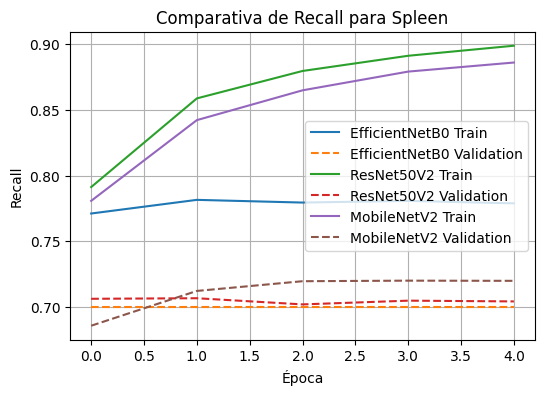

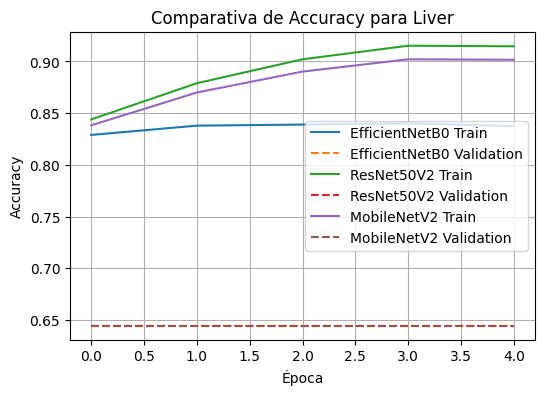

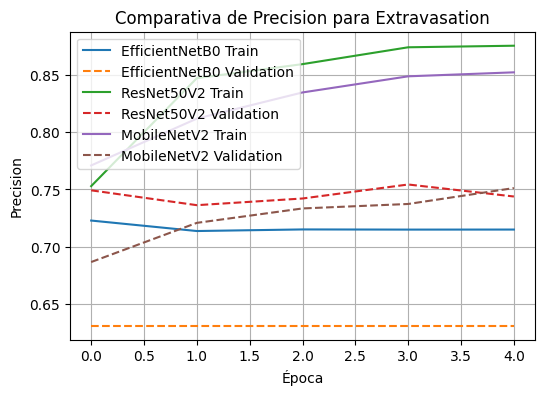

In [37]:
import matplotlib.pyplot as plt

def plot_metric_comparison(metric_name, organ_name, histories_dict):
    """
    Grafica la métrica de entrenamiento y validación para un órgano específico,
    comparando todos los modelos en el diccionario de historiales.
    """
    plt.figure(figsize=(6, 4))

    # Capitalizamos los nombres para los títulos
    metric_title = metric_name.capitalize()
    organ_title = organ_name.capitalize()

    for model_name, history in histories_dict.items():
        # Construimos las llaves para acceder a los datos del historial
        train_metric_key = f'{organ_name}_{metric_name}'
        val_metric_key = f'val_{organ_name}_{metric_name}'

        # Graficamos la métrica de entrenamiento (línea sólida)
        plt.plot(history.history[train_metric_key], label=f'{model_name} Train', linestyle='-')
        # Graficamos la métrica de validación (línea punteada)
        plt.plot(history.history[val_metric_key], label=f'{model_name} Validation', linestyle='--')

    plt.title(f'Comparativa de {metric_title} para {organ_title}')
    plt.ylabel(metric_title)
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- EJEMPLOS DE CÓMO USAR LA FUNCIÓN ---

# Ejemplo 1: Comparar el RECALL para la detección de lesiones en el Bazo (Spleen)
plot_metric_comparison(metric_name='recall', organ_name='spleen', histories_dict=histories)

# Ejemplo 2: Comparar la ACCURACY para la clasificación del Hígado (Liver)
plot_metric_comparison(metric_name='accuracy', organ_name='liver', histories_dict=histories)

# Ejemplo 3: Comparar la PRECISION para la detección de Extravasación
plot_metric_comparison(metric_name='precision', organ_name='extravasation', histories_dict=histories)

### ACURACY
#plot_metric_comparison(metric_name='accuracy', organ_name='bowel', histories_dict=histories)
#plot_metric_comparison(metric_name='accuracy', organ_name='extravasation', histories_dict=histories)
#plot_metric_comparison(metric_name='accuracy', organ_name='kidney', histories_dict=histories)
#plot_metric_comparison(metric_name='accuracy', organ_name='liver', histories_dict=histories)
#plot_metric_comparison(metric_name='accuracy', organ_name='spleen', histories_dict=histories)




## Creacion de graficos más ordenados
- el codigo se esta repitiendo mucho crear funcion para llamar a los multitable

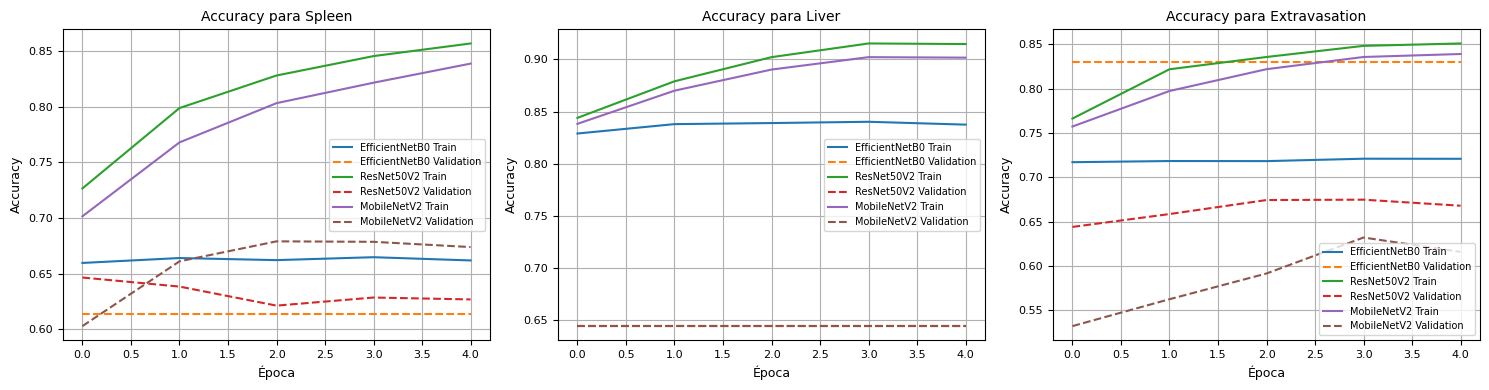

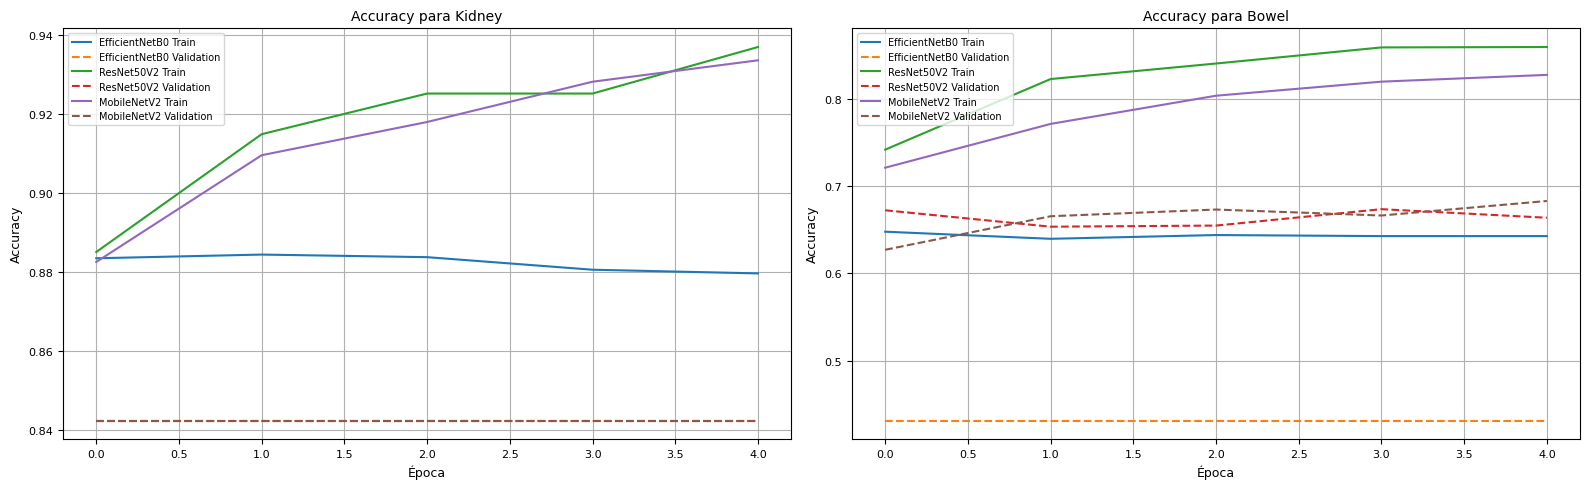

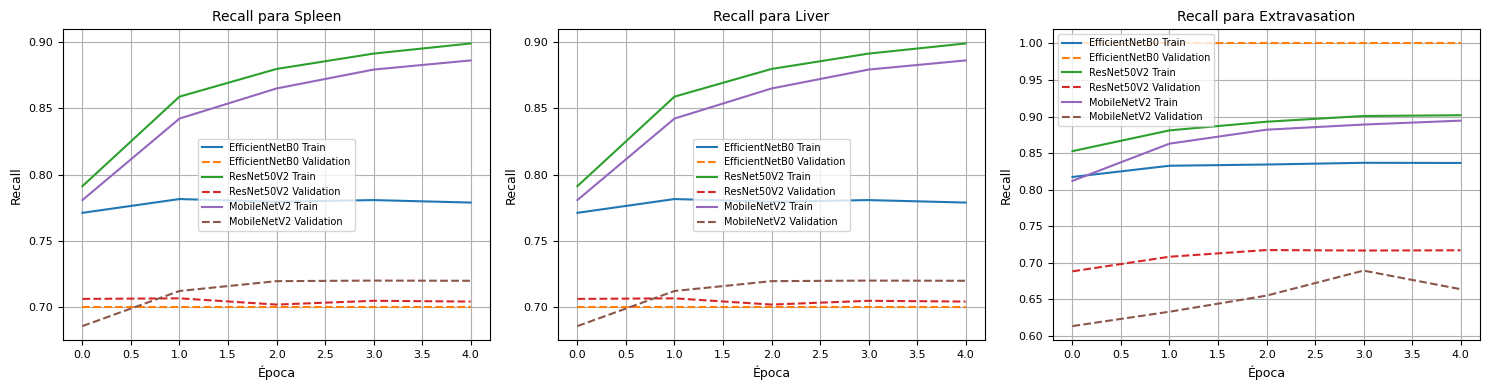

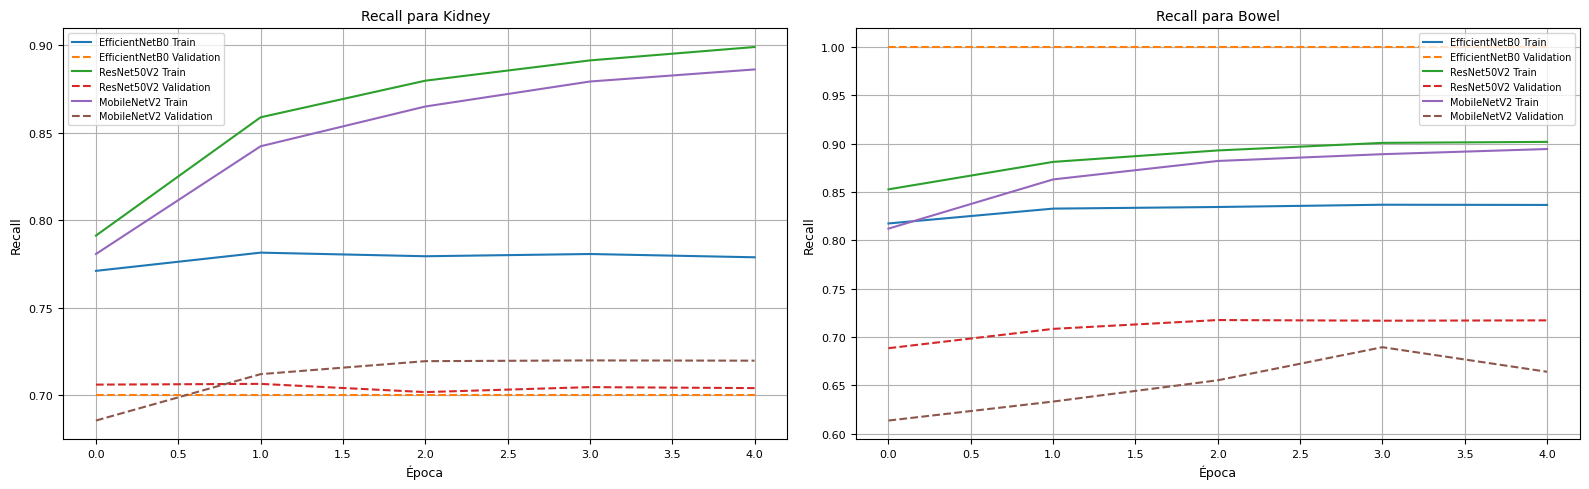

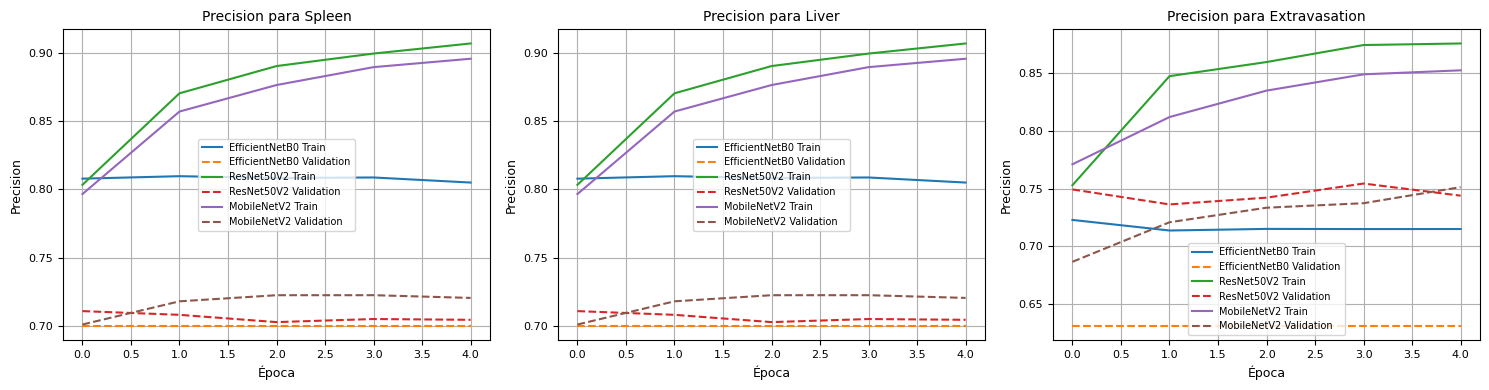

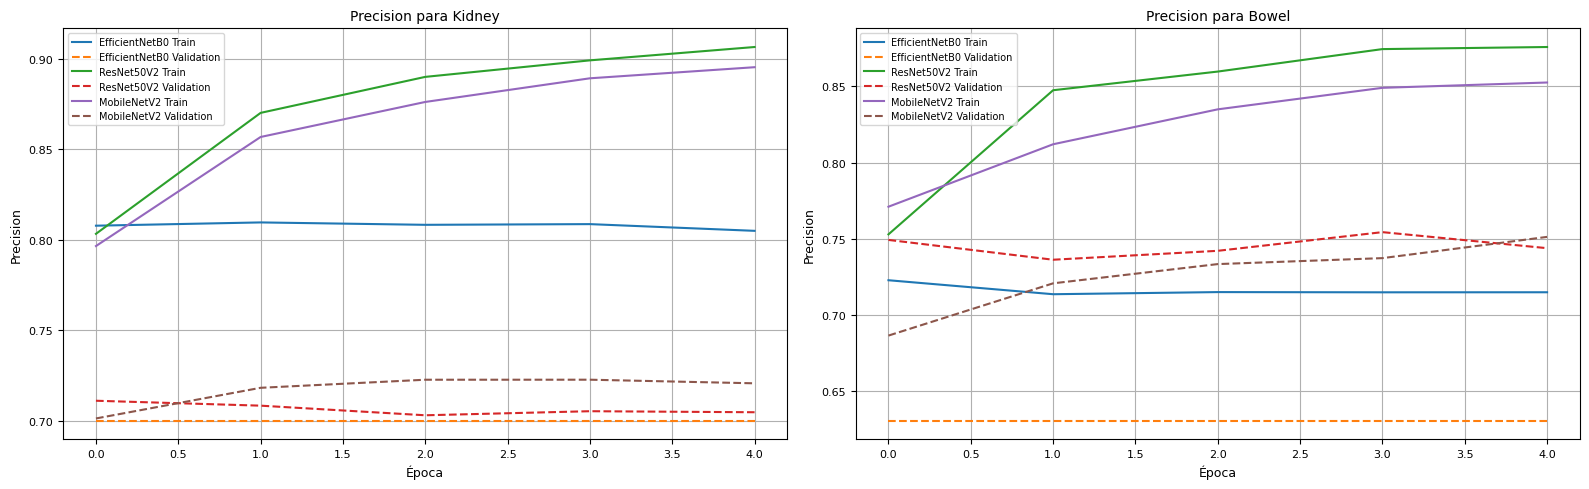

In [39]:
import matplotlib.pyplot as plt

def plot_metric_comparison_multiple(metric_names, organ_names, histories_dict, figsize_per_plot=(6, 4), legend_fontsize=8):
    """
    Grafica múltiples métricas u órganos en una misma fila para comparación.
    
    Parámetros:
    - metric_names: lista de nombres de métricas a graficar
    - organ_names: lista de nombres de órganos/organizaciones
    - histories_dict: diccionario con los historiales de entrenamiento
    - figsize_per_plot: tamaño de cada gráfico individual
    - legend_fontsize: tamaño de fuente para la leyenda (por defecto 8)
    """
    num_plots = len(metric_names) if metric_names else len(organ_names)
    fig, axes = plt.subplots(1, num_plots, figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]))
    
  
    if num_plots == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if metric_names and organ_names:
            # Si tenemos ambas listas, usamos la combinación de métrica y órgano
            metric_name = metric_names[i]
            organ_name = organ_names[i]
            title = f'{metric_name.capitalize()} para {organ_name.capitalize()}'
            train_metric_key = f'{organ_name}_{metric_name}'
            val_metric_key = f'val_{organ_name}_{metric_name}'
        elif metric_names:
            # Si solo tenemos métricas, asumimos que es para el mismo órgano
            metric_name = metric_names[i]
            organ_name = organ_names[0] if organ_names else 'default'
            title = f'{metric_name.capitalize()}'
            train_metric_key = f'{organ_name}_{metric_name}'
            val_metric_key = f'val_{organ_name}_{metric_name}'
        else:
            # Si solo tenemos órganos, asumimos que es para la misma métrica
            organ_name = organ_names[i]
            metric_name = metric_names[0] if metric_names else 'accuracy'
            title = f'{organ_name.capitalize()}'
            train_metric_key = f'{organ_name}_{metric_name}'
            val_metric_key = f'val_{organ_name}_{metric_name}'
        
        for model_name, history in histories_dict.items():
            # Graficamos la métrica de entrenamiento (línea sólida)
            ax.plot(history.history[train_metric_key], label=f'{model_name} Train', linestyle='-')
            # Graficamos la métrica de validación (línea punteada)
            ax.plot(history.history[val_metric_key], label=f'{model_name} Validation', linestyle='--')
        
        ax.set_title(title, fontsize=10)  # Título un poco más pequeño
        ax.set_ylabel(metric_name.capitalize(), fontsize=9)
        ax.set_xlabel('Época', fontsize=9)
        ax.legend(fontsize=legend_fontsize)  # Leyenda más pequeña
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=8)  # Números más pequeños en los ejes
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con leyenda pequeña
plot_metric_comparison_multiple(
    metric_names=['accuracy', 'accuracy', 'accuracy'],
    organ_names=['spleen', 'liver', 'extravasation'],
    histories_dict=histories,
    figsize_per_plot=(5, 4),
    legend_fontsize=7  #leyenda pequeña
)
plot_metric_comparison_multiple(
    metric_names=['accuracy', 'accuracy'],
    organ_names=['kidney', 'bowel'],
    histories_dict=histories,
    figsize_per_plot=(8, 5),
    legend_fontsize=7  
)

plot_metric_comparison_multiple(
    metric_names=['recall', 'recall', 'recall'],
    organ_names=['spleen', 'liver', 'extravasation'],
    histories_dict=histories,
    figsize_per_plot=(5, 4),
    legend_fontsize=7  
)
plot_metric_comparison_multiple(
    metric_names=['recall', 'recall'],
    organ_names=['kidney', 'bowel'],
    histories_dict=histories,
    figsize_per_plot=(8, 5),
    legend_fontsize=7  
)

plot_metric_comparison_multiple(
    metric_names=['precision', 'precision', 'precision'],
    organ_names=['spleen', 'liver', 'extravasation'],
    histories_dict=histories,
    figsize_per_plot=(5, 4),
    legend_fontsize=7  
    
plot_metric_comparison_multiple(
    metric_names=['precision', 'precision'],
    organ_names=['kidney', 'bowel'],
    histories_dict=histories,
    figsize_per_plot=(8, 5),
    legend_fontsize=7  
)
    

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- PASO 1: Definir nombres de clases y un diccionario de modelos ---
# Esto nos ayudará a llamar a la función de forma más sencilla.

ORGANS = ["bowel", "extravasation", "kidney", "liver", "spleen"]
CLASS_NAMES = {
    "bowel": ["Sano", "Lesión"],
    "extravasation": ["Sano", "Lesión"],
    "kidney": ["Sano", "Bajo", "Alto"],
    "liver": ["Sano", "Bajo", "Alto"],
    "spleen": ["Sano", "Bajo", "Alto"]
}

# Asumimos que tus modelos entrenados están en estas variables
# (Si tienen otros nombres, ajústalos aquí)
MODELS = {
    'EfficientNetB0': model_efficientnet,
    'ResNet50V2': model_resnet,
    'MobileNetV2': model_mobilenet
}

# --- PASO 2: La función para calcular y graficar la matriz ---

def plot_confusion_matrix(model_name, organ_name, dataset):
    """
    Calcula y grafica la matriz de confusión para un modelo y órgano específicos.
    
    Args:
        model_name (str): El nombre del modelo (ej. 'ResNet50V2').
        organ_name (str): El nombre del órgano (ej. 'kidney').
        dataset (tf.data.Dataset): El dataset de validación (val_ds).
    """
    model = MODELS[model_name]
    organ_index = ORGANS.index(organ_name)
    class_names = CLASS_NAMES[organ_name]

    # Obtenemos todas las predicciones y etiquetas del dataset de validación
    all_true_labels = []
    all_pred_labels = []

    print(f"Generando predicciones para el modelo {model_name}...")
    for images, labels_tuple in dataset:
        # Obtenemos las predicciones del modelo para el lote actual
        pred_probs_list = model.predict(images, verbose=0)
        
        # Seleccionamos las etiquetas y predicciones para el órgano de interés
        true_labels_batch = labels_tuple[organ_index].numpy()
        pred_probs_batch = pred_probs_list[organ_index]
        
        # Convertimos probabilidades y one-hot a etiquetas de clase (0, 1, 2...)
        # Manejamos el caso binario (forma [batch, 1]) y categórico (forma [batch, 3])
        if pred_probs_batch.shape[1] == 1: # Caso Binario
            true_labels = true_labels_batch.flatten()
            pred_labels = (pred_probs_batch > 0.5).astype(int).flatten()
        else: # Caso Categórico
            true_labels = np.argmax(true_labels_batch, axis=1)
            pred_labels = np.argmax(pred_probs_batch, axis=1)
        
        all_true_labels.append(true_labels)
        all_pred_labels.append(pred_labels)

    # Concatenamos los resultados de todos los lotes
    y_true = np.concatenate(all_true_labels)
    y_pred = np.concatenate(all_pred_labels)
    
    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Graficamos la matriz
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title(f'Matriz de Confusión para {organ_name.capitalize()} - Modelo: {model_name}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

Generando predicciones para el modelo ResNet50V2...


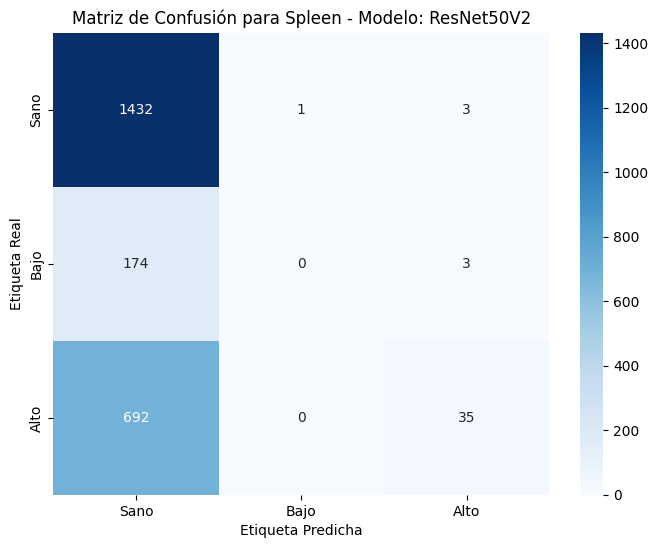

In [49]:
# Supongamos que ResNet50V2 fue tu mejor modelo en general
plot_confusion_matrix(model_name='ResNet50V2', 
                      organ_name='spleen', 
                      dataset=val_ds)

Generando predicciones para el modelo EfficientNetB0...


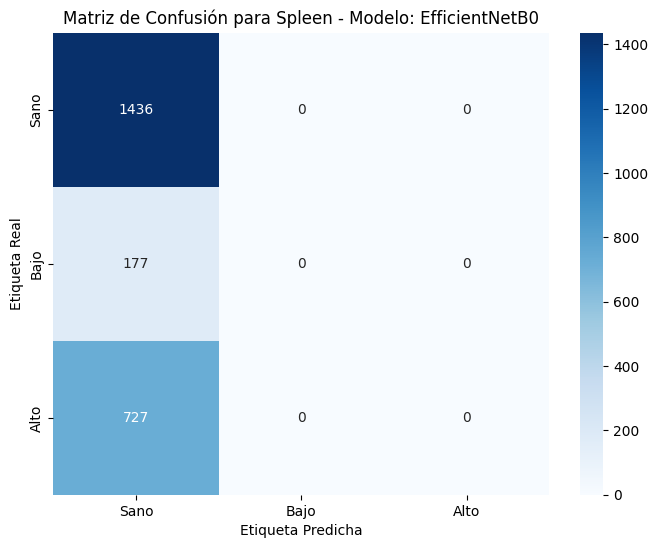

In [51]:
plot_confusion_matrix(model_name='EfficientNetB0', 
                      organ_name='spleen', 
                      dataset=val_ds)

Generando predicciones para el modelo MobileNetV2...


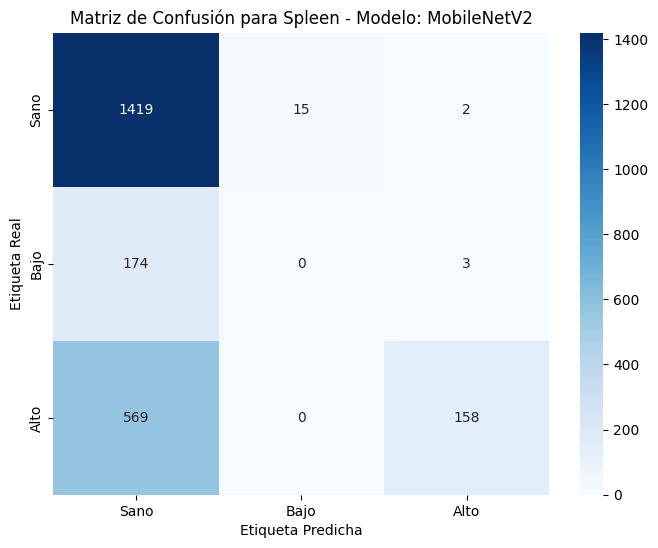

In [54]:
plot_confusion_matrix(model_name='MobileNetV2', 
                      organ_name='spleen', 
                      dataset=val_ds)